# Normal model parameter recovery with mapped variance

Starting from $X\sim N\left(\mu,\,\sigma^2\right)$ use Bayesian approach to sample from probability distirbutions for $\sigma^2$ and $\mu$. Instead of directly treating variance as one of the variables, map it into $\lambda=\log\sigma^2$

In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import tensorflow as tf
import tensorflow_probability as tfp

import typing as tp

import scipy as sp
import scipy.stats as sp_stats
import scipy.special as sp_spec

2021-10-30 03:04:27.211920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-30 03:04:27.211940: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Probabilistic model

The data will be assumed to arise from a normal distribution with mean $\mu$ and variance $\sigma^2$

$$
x\sim N\left(\mu,\,\sigma^2\right)=N\left(\mu,\,\exp\left(\lambda\right)\right)
$$

The prior for the mean will be normal distribution with mean $\mu_0$ and variance $\sigma^2/\left(\nu+1\right)$ where a good candidate for $\mu_0$ is sample mean. $\nu$ is the number of degrees of freedom used for the prior:

$$
\mu\sim N\left(\mu_0,\,\sigma^2/\nu\right)=N\left(\mu_0,\,\exp\left(\lambda\right)/\nu\right)
$$

The distribution for variance will be the inverse chi-2 with scale parameter $s^2$ (sample variance) and $\nu$ as the number of degrees of freedom:

$$
\sigma^2 \sim \mbox{Inv-}\chi^2\left(\nu,\,s^2\right)=\mbox{Inv-}\Gamma\left(\frac{\nu}{2},\,\frac{\nu s^2}{2}\right)
$$

Conveniently, the distribution for $\exp\left(\lambda\right)=\sigma^2$ is then $\mbox{Exp-Inv-}\Gamma$

### PDF for $\lambda$

The analytic expression for the pdf of $\lambda$ is:

$$
p\left(\lambda\right)\,d\lambda=\frac{1}{\Gamma\left(\frac{\nu}{2}\right)}\cdot\left(\frac{\nu s^2}{2 e^\lambda}\right)^{\frac{\nu}{2}}\cdot\exp\left(-\left(\frac{\nu s^2}{2 e^\lambda}\right)\right)\,d\lambda
$$

Below, I want to compare it with what is provided by TFP. In particular, it should be that:

$$
\lambda \sim \mbox{Exp-Inv-}\Gamma\left(\frac{\nu}{2},\,\frac{\nu s^2}{2}\right)
$$

2021-10-30 03:04:28.466820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-30 03:04:28.466839: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-30 03:04:28.466856: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cryo-Latitude-7300): /proc/driver/nvidia/version does not exist
2021-10-30 03:04:28.467064: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-30 03:04:28.640654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the 

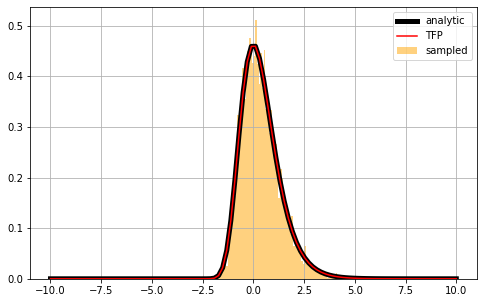

In [2]:
nu = 3
s2 = 1.0

### compute basic numpy representation
lam_arr = np.linspace(-10, 10, 100)
arg_arr = (nu * s2)/(2 * np.exp(lam_arr))
#
pdf_lam_arr = (1/sp_spec.gamma(nu/2)) * ((arg_arr)**(nu/2)) * np.exp(-arg_arr)


### compute TFP representation
exp_inv_gamma = tfp.distributions.ExpInverseGamma(nu/2, nu*s2/2)
#
tfp_pdf_lam_arr = exp_inv_gamma.prob(lam_arr).numpy()
sampled_lam = exp_inv_gamma.sample(5000).numpy()

fig, ax = pp.subplots(figsize=(8, 5))
ax.plot(lam_arr, pdf_lam_arr, linewidth=5, color='k', label='analytic')
ax.plot(lam_arr, tfp_pdf_lam_arr, color='r', label='TFP')
_ = ax.hist(sampled_lam, density=True, bins=100, alpha=0.5, color='orange', label='sampled')
ax.grid()
ax.legend()
#ax.set_yscale('log')
#ax.set_ylim([max(pdf_lam_arr)*1e-5, max(pdf_lam_arr)*2])

Indeed, the match between expected and implemented distirbutions is good

### Summary

With that, the probabilistic model is:

$$
\begin{align}
\left(x_1,\dots\right)\,\Big|\,\mu,\,\lambda &\sim N\left(\mu,\,\exp\left(\lambda\right)\mbox{Id}\right) \\
\mu \,\Big|\,\lambda &\sim N\left(\bar{x},\,\frac{\exp\left(\lambda\right)}{\nu+1}\right) \\
\lambda &\sim \mbox{Exp-Inv-}\Gamma\left(\frac{\nu}{2},\frac{\nu s^2}{2}\right)
\end{align}
$$

Text(0.5, 1.0, 'Marginal prior for $\\sigma^2$')

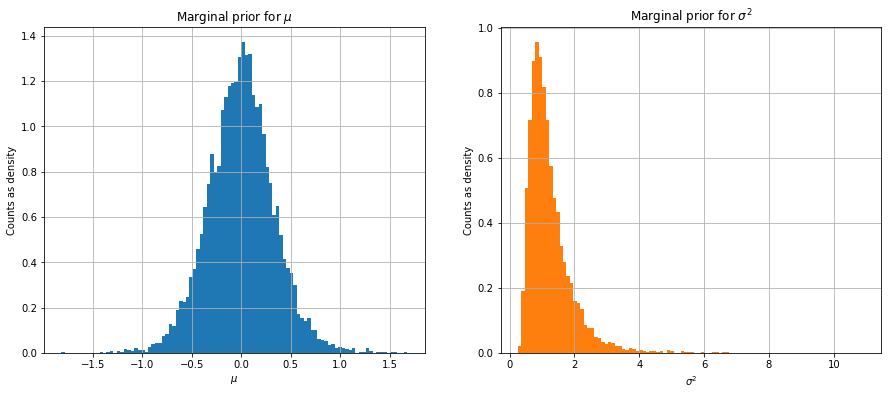

In [3]:
def get_prior_distribution(
    prior_nu: int=5,
    prior_s2: float=1.0,
    prior_xbar: float=0.0
)->tfp.distributions.JointDistribution:
    """
    Given key parameters initialize and return prior distribution for mean and variance of the normal model. The names
    for the variables are `lam` for logarithm of variance and `mu` for mean, in that order
    
    Arguments:
    ----------
        prior_nu: equivalent to degrees of freedom -1 for the prior sample of data
        prior_s2: equivalent prior sample variance
        prior_xbar: equivalent priior sample mean
        
    Returns:
    --------
        joint distribution for `lam` and `mu`
    """
    
    # wrap the inputs to avoid float32/float64 clases
    tf_prior_nu = tf.constant(prior_nu, dtype=tf.float32)
    tf_prior_s2 = tf.constant(prior_s2, dtype=tf.float32)
    tf_prior_xbar = tf.constant(prior_xbar, dtype=tf.float32)
    
    # NB! in TFP the specification is to pass standard deviation rather than variance!
    prior_distribution = tfp.distributions.JointDistributionNamed({
        'lam': tfp.distributions.ExpInverseGamma( tf_prior_nu/2., tf_prior_nu*tf_prior_s2/2. ),
        'mu': lambda lam: tfp.distributions.Normal( tf_prior_xbar, tf.sqrt(tf.exp(lam)/(tf_prior_nu+1)) )
    })
    
    return prior_distribution

####

prior_distribution = get_prior_distribution(
    prior_nu=10,
    prior_s2=1.,
    prior_xbar=0.0
)
prior_samples = prior_distribution.sample(10000)

fig, (ax, ax2) = pp.subplots(1, 2, figsize=(15, 6))
#
_ = ax.hist(prior_samples['mu'].numpy(), density=True, bins=100, color=cm.tab10(0))
ax.set_xlabel('$\mu$')
ax.set_ylabel('Counts as density')
ax.grid()
ax.set_title('Marginal prior for $\mu$')
#
_ = ax2.hist(np.exp(prior_samples['lam'].numpy()), density=True, bins=100, color=cm.tab10(1))
ax2.set_xlabel('$\sigma^2$')
ax2.set_ylabel('Counts as density')
ax2.grid()
ax2.set_title('Marginal prior for $\sigma^2$')

## Prepare samples

Samples which will be used to extract the chosen parameters of the normal distribution

Text(0, 0.5, 'Counts as density')

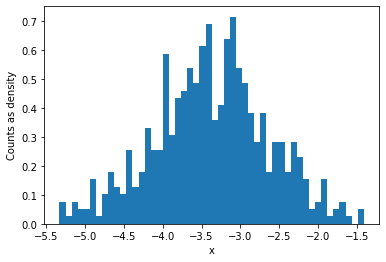

In [4]:
chosen_sig2 = 0.5
chosen_lam = np.log(chosen_sig2)
chosen_mu = -3.4
chosen_sample_count = 500

# NB! parametrization for TFP.Normal is by the standard deviation, not variance!
sampled_data = tfp.distributions.Normal(
    loc=chosen_mu, scale=np.sqrt(chosen_sig2)
).sample(chosen_sample_count).numpy()

fig, ax = pp.subplots()
#
_ = ax.hist(sampled_data, bins=50, density=True)
ax.set_xlabel('x')
ax.set_ylabel('Counts as density')

## Log-likelihood and prior/posterior 

In [5]:
def log_lkhd(
    mu: tf.Tensor,
    lam: tf.Tensor,
    data: tf.Tensor=tf.constant(sampled_data)
)->tf.Tensor:
    """
    Compute likelihood for data points given mean and variance (mu, lam). Incoming mu and lam can 
    be tensors. data is assumed to be a 1d tensor. Internally data extended into a [N, *] shape where
    N is the number of data points along the zeroth dimnesion of `data` argument, and * are the common
    dimensions of mu and sig2. 
    
    Assumed model is: x~N(mu, exp(lam))
    
    After expansion, the log_probability for all individual data points is computed, for all values in mu, lam.
    The result is then collapsed along the zeroth dimension. The resulting [*]-dimensional tensor, with log-prob
    for all points, is returned
    
    Arguments:
    ----------
        mu: tensor of mean values
        lam: tensor of logarithm of variances, same shape as mu, this is not a multivariate model. All cells
            of mu and lam are simply processed in parallel
            
        data: data points, an (N,)-shaped tensor
        
    Returns:
    --------
        Tensor of log-likelihooeds
    """
    
    # reshape to have data running along the zeroth axis, with lam and mu running along others
    data_reshaped = tf.reshape(data, [data.shape[0], *[1 for _ in mu.shape]])
    
    # define probabilistic model
    data_model = tfp.distributions.Normal(mu, tf.sqrt(tf.exp(lam)))
    
    # compute log-likelihood
    log_lkhd_per_sample = data_model.log_prob(data_reshaped)
    
    # collapse along zeroth dimension, to get probability for all data points
    log_lkhd_agg = tf.reduce_sum(log_lkhd_per_sample, axis=0)
    
    return log_lkhd_agg

####

def log_post_prob(
    mu: tf.Tensor,
    lam: tf.Tensor,
    prior_distribution: tfp.distributions.JointDistribution,
    log_lkhd_func: tp.Callable[[tf.Tensor, tf.Tensor, tf.Tensor], tf.Tensor],
    data: tf.Tensor=tf.constant(sampled_data)
)->tf.Tensor:
    """
    Compute log of non-normalized posterior distribution given prior, data and likelihood
    
    Arguments:
    ----------
        mu: mean for the model - trying to fit that. tensor with arbitrary shape
        lam: logarithm of variance for the model, same as mu
        prior_distribution: Joint prior probability distribution for the data. Should take in `lam` and 
            `mu` as inputs and return log-probability of prior beliefs (via `log_prob`)
            
        log_lkhd_func: function that takes in mu, sig2 and data, as tensors, and returns the 
            log-likelihood for all the data points, given mu and lam. See `log_lkhd`
        data: (N,)-shaped tensor of data points for N data points
        
    Returns:
    --------
        tensor of posterior log-probabilities, that is shaped like mu and sig
    """
    
    # compute prior log-probability
    log_prior_tens = prior_distribution.log_prob(lam=lam, mu=mu)
    
    # compute likelihood
    log_lkhd_tens = log_lkhd_func(mu, lam, data)
    
    # compute posterior log-prob
    log_post_tens = log_lkhd_tens + log_prior_tens
    
    return log_post_tens


####


prior_distribution = get_prior_distribution(
    prior_nu=10,
    prior_s2=1.,
    prior_xbar=0.0
)

print(
    log_post_prob(
        mu=tf.constant([[chosen_mu, 0.2, 0.7], [-0.3, 0.7, -0.9]]), 
        lam=tf.math.log(tf.constant([[chosen_sig2, 1.2, 3.4], [4.0, 0.9, 3.1]])),
        prior_distribution=prior_distribution,
        log_lkhd_func=log_lkhd,
        data=tf.constant(sampled_data, dtype=tf.float32)
    )
)

tf.Tensor(
[[ -686.6351 -3285.2727 -2031.8918]
 [-1435.9152 -5205.901  -1285.404 ]], shape=(2, 3), dtype=float32)


## MCMC sampling

Next, use Markov-Chain Monte Carlo to sample from log-posterior

In [ ]:
######### RANDOM-WALK METROPOLIS
@tf.function(jit_compile=True)
def rwm_mcmc_sample(
    log_post_func: tp.Callable[[tf.Tensor, tf.Tensor], tf.Tensor],
    init_state: tp.List[tf.Tensor],
    num_burnin_steps: int=1000,
    num_results: int=100
)->tf.Tensor:
    """
    Run MCMC using basic RandomWalkMetropolis.
    
    Arguments:
    ----------
        log_post_func: function that accepts tensors for mu and lam and returns log-probability for the posterior
        init_state: initial state for MCMC, list of two tensors, for mu and lam, with shapes (K, 1) where K is the number
                    of chains
        num_burnin_steps: number of burn-in steps see `tensorflow_probability.mcmc.sample_chain`
        num_results: number of results per chain see `tensorflow_probability.mcmc.sample_chain`
        
    Returns:
    --------
        A list of tensors ([mu, lam]) with the results. The shape of the tensors includes number of results and 
        number of chains
    """
    
    # basic kernel
    rwm_kernel = tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=log_post_func
    )
    
    # sample chain
    sampled_chain = tfp.mcmc.sample_chain(
        kernel=rwm_kernel,
        trace_fn=None,
        current_state=init_state,
        num_burnin_steps=num_burnin_steps,
        num_results=num_results
    )
    
    return sampled_chain

######### HMC

@tf.function(jit_compile=True)
def hmc_mcmc_sample(
    log_post_func: tp.Callable[[tf.Tensor, tf.Tensor], tf.Tensor],
    init_state: tp.List[tf.Tensor],
    num_burnin_steps: int=1000,
    num_results: int=100,
    step_size: float=0.05,
    num_leapfrog_steps=3,
)->tf.Tensor:
    """
    Run MCMC using basic Hamiltonian Monte-Carlo
    
    Arguments:
    ----------
        log_post_func: function that accepts tensors for mu and lam and returns log-probability for the posterior
        init_state: initial state for MCMC, list of two tensors, for mu and lam, with shapes (K, 1) where K is the number
                    of chains
        num_burnin_steps: number of burn-in steps see `tensorflow_probability.mcmc.sample_chain`
        num_results: number of results per chain see `tensorflow_probability.mcmc.sample_chain`
        step_size: size of the step for HMC
        num_leapfrog_steps: see HMC
        
    Returns:
    --------
        A list of tensors ([mu, lam]) with the results. The shape of the tensors includes number of results and 
        number of chains
    """
    
    # basic kernel
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_post_func,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size
    )
    
    ahmc_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=hmc_kernel,
        num_adaptation_steps=int(num_burnin_steps * 0.8)
    )
    
    sampled_chain = tfp.mcmc.sample_chain(
        kernel=ahmc_kernel,
        trace_fn=None,
        current_state=init_state,
        num_burnin_steps=num_burnin_steps,
        num_results=num_results
    )
    
    return sampled_chain


###############

sample_mean = np.mean(sampled_data)
sample_variance = np.sum((sampled_data-sample_mean)**2)/(len(sampled_data)-1)

prior_distribution = get_prior_distribution(
    prior_nu=2,# two degrees of freedom to fix sig2 and mu
    prior_s2=sample_variance,
    prior_xbar=sample_mean
)

# rig the posterior log-probability so that it only needs
# two inputs
rigged_log_post_func = lambda mu, lam: \
    log_post_prob(
        mu=mu, 
        lam=lam,
        prior_distribution=prior_distribution,
        log_lkhd_func=log_lkhd,
        data=tf.constant(sampled_data, dtype=tf.float32)
    )

# set-up initial state
# list of tensors, one tensor per parameter
# here the parameters are mean and variance, so two parameters
# the shape of the tensors should be (*, 1) where the number of elements along the zeroth
# dimension determines the number of chains
chain_count = 100
# will initialize chains from prior
initial_tens_dict = prior_distribution.sample(chain_count)

mcmc_init_state = [
    tf.reshape(initial_tens_dict['mu'], shape=[chain_count, 1]),
    tf.reshape(initial_tens_dict['lam'], shape=[chain_count, 1])
]

num_burnin_steps = 500000
samples_per_chain = 100

####
print('Running chain')

# run the chain
sampler_choice = 'hmc'

if sampler_choice == 'hmc':
    pass
    chain_list = hmc_mcmc_sample(
        log_post_func=rigged_log_post_func,
        init_state=mcmc_init_state,
        num_burnin_steps=num_burnin_steps,
        num_results=samples_per_chain,
        step_size=1.0,
        num_leapfrog_steps=3
    )
else:
    chain_list = rwm_mcmc_sample(
        log_post_func=rigged_log_post_func,
        init_state=mcmc_init_state,
        num_burnin_steps=num_burnin_steps,
        num_results=samples_per_chain
    )

print('Done')

Running chain


2021-10-30 03:04:30.515063: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x55969fffd9a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-30 03:04:30.515091: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-10-30 03:04:30.557671: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-10-30 03:04:30.634629: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:96] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2021-10-30 03:04:32.942300: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [ ]:
# unpack to dictionary
key_order = [
    'mu',
    'lam'
]
#
results_dict = {
    key: chain_list[i_key].numpy().reshape(-1)
    for i_key, key in enumerate(key_order)
}

results_dict = {}
results_dict['mu'] = chain_list[0].numpy().reshape(-1)
results_dict['sig2'] = np.exp(chain_list[1].numpy().reshape(-1))

## Inspect results

Plot the results comparing the target values with frequentist and numerical Bayesian estimates

In [ ]:
fig, ax_list = pp.subplots(1, len(results_dict), figsize=(10*len(results_dict), 7))

# choose confince interval
confidence_level = 0.9
lw = 3
 
# mark where the actual chosen values were
ax_list[0].axvline(
    chosen_mu, linestyle='--',
    color='r',
    label=f'target value ({chosen_mu:.2f})',
    linewidth=lw
)
#
ax_list[1].axvline(
    chosen_sig2,
    linestyle='--',
    color='r',
    label=f'target value ({chosen_sig2:.2f})',
    linewidth=lw
)

# work out the confidence interval that corresponds to frequentist statistics
sample_mean = np.mean(sampled_data)
sample_variance = np.sum((sampled_data-sample_mean)**2)/(len(sampled_data)-1)
#
t_ci_lim_norm = sp_stats.t(df=len(sampled_data)-1).ppf([(1-confidence_level)/2, 1-(1-confidence_level)/2])
freq_mu_lim = sample_mean + t_ci_lim_norm * np.sqrt(sample_variance/len(sampled_data))
#
ax_list[0].axvline(
    np.min(freq_mu_lim),
    linestyle='--',
    color='green',
    label=f'lower freq limit ({min(freq_mu_lim):.3f})',
    linewidth=lw
)
#
ax_list[0].axvline(
    np.max(freq_mu_lim),
    linestyle='--',
    color='green',
    label=f'upper freq limit ({max(freq_mu_lim):.3f})',
    linewidth=lw
)
#####################
chi2_ci_lim_norm = sp_stats.chi2(df=len(sampled_data)-1).ppf([(1-confidence_level)/2, 1-(1-confidence_level)/2])
freq_sig2_lim = (len(sampled_data)-1)*sample_variance/chi2_ci_lim_norm
#
ax_list[1].axvline(
    np.min(freq_sig2_lim),
    linestyle='--',
    color='green',
    label=f'lower freq limit ({min(freq_sig2_lim):.3f})',
    linewidth=lw
)
#
ax_list[1].axvline(
    np.max(freq_sig2_lim),
    linestyle='--',
    color='green',
    label=f'upper freq limit ({max(freq_sig2_lim):.3f})',
    linewidth=lw
)
#
  
#################
# plot results
for i_key, ((key, arr), ax) in enumerate(zip(results_dict.items(), ax_list)):
    clean_arr = arr[np.isnan(arr)==False]
    
    # compute confidence interval for the specific param
    ci_min = np.quantile(clean_arr, (1-confidence_level)/2)
    ci_max = np.quantile(clean_arr, 1-(1-confidence_level)/2)
    
    ax.hist(
        arr,
        bins=50,
        label=f'{key}: [{ci_min:.3f}, {ci_max:.3f}]',
        color=cm.tab10(i_key),
        density=True
    )
    #
    ax.axvline(ci_min, linestyle='--', color='k', label='Bayesian CI', linewidth=lw)
    ax.axvline(ci_max, linestyle='--', color='k', label='Bayesian CI', linewidth=lw)
    #
    ax.grid()
    ax.legend()
    ax.set_xlabel(f'{key}')
    ax.set_ylabel('count as density')
    
    ci_width = ci_max-ci_min
    ci_mid = (ci_max+ci_min)/2
    ax.set_xlim([ci_mid-ci_width, ci_mid+ci_width])
    
##

ax_list[0].set_xlim([-4, -3])

The results are compareable with naive fitting of $\sigma^2$, but the actual distribution for $\sigma^2$ ends up being much smoother 